# Test plugins

In [16]:
import plugins as p

In [15]:
import importlib
p = importlib.import_module('plugins')
importlib.reload(p)

<module 'plugins' from 'c:\\Users\\ydebray\\Downloads\\openai\\plugins\\plugins.py'>

In [2]:
import os
import openai
import tomli
with open('../.streamlit/secrets.toml','rb') as f:
    toml_dict = tomli.load(f)
openai.api_key = toml_dict['OPEN_AI_KEY']
os.environ['SERP_API_KEY'] = toml_dict['SERP_API_KEY']

## Plugin Decision

In [3]:
with open("PluginDecisionPrompt.txt") as f:
    pluginDecisionPrompt = f.read()
# print(pluginDecisionPrompt)

In [74]:
plugins = ['search','MATLAB']
desc = {
    'search' : 'Useful for when you need to answer questions about current events.',
    'MATLAB' : 'Useful for when performing numerical computing and trying to solve mathematical problems'
    }
examples = {
    'search' : 'What movie won best picture in 2023?',
    'MATLAB' : 'What is the 10th element of the Fibonacci suite'
    }
promptIntro = '''You are an AI language model that decides whether extra information is needed before you would be able to respond to a hypothetical prompt. 
For every prompt you receive, you will decide whether one of the available plugins to use.
'''
# promptCoreTemplate = f'- {tool} : {desc[tool]}'
promptCore = ''.join([f'- {tool} : {desc[tool]}\n' for tool in plugins])
promptExample = '''
Here's some examples of prompts you'll get and the response you should give:

''' + ''.join([f'  USER: {examples[tool]}\n  BOT: {tool}\n\n' for tool in plugins])
promptEnd = '''
Give a single word answer with the tool chosen to answer the prompt.
If you're very confident that you don't need extra information, respond with the string "null".
'''
print(promptIntro+promptCore+promptExample+promptEnd)

You are an AI language model that decides whether extra information is needed before you would be able to respond to a hypothetical prompt. 
For every prompt you receive, you will decide whether one of the available plugins to use.
- search : Useful for when you need to answer questions about current events.
- MATLAB : Useful for when performing numerical computing and trying to solve mathematical problems

Here's some examples of prompts you'll get and the response you should give:

  USER: What movie won best picture in 2023?
  BOT: search

  USER: What is the 10th element of the Fibonacci suite
  BOT: MATLAB


Give a single word answer with the tool chosen to answer the prompt.
If you're very confident that you don't need extra information, respond with the string "null".



In [36]:

prompt = 'What movie won best picture in 2023?'
p.pick_plugin(prompt,plugins,desc)

'search'

In [38]:
prompt = 'What is the square root of 42?'
p.pick_plugin(prompt,plugins)

'MATLAB'

In [37]:
prompt = 'What does 2+2?'
p.pick_plugin(prompt,plugins)

'null'

In [25]:
messages = []
prompt = 'What movie won best picture in 2023?'
system=pluginDecisionPrompt
if system:
    messages.append({'role': 'system', 'content': system})
messages.append({'role': 'user', 'content': prompt })
messages
completion = openai.ChatCompletion.create(
      model='gpt-3.5-turbo',
        messages= messages
  )
completion.choices[0].message.content

'{"type":"search", "data":"best picture 2023"}'

In [54]:
prompt = 'What movie won best picture in 2023?'
plugin = plugins.pick_plugin(prompt)
plugin


{'type': 'search', 'data': 'best picture 2023'}

## Test plugins

In [8]:
plugins = p.load_plugins()
plugins

[{'name': 'search',
  'desc': 'Useful for when you need to answer questions about current events.',
  'example': 'What movie won best picture in 2023?'},
 {'name': 'MATLAB',
  'desc': 'Useful for when performing numerical computing and trying to solve mathematical problems',
  'example': 'What is the 10th element of the Fibonacci suite'}]

In [9]:
prompt = 'What movie won best picture in 2023?'
plugin = p.pick_plugin(prompt,plugins)
plugin

'search'

In [12]:
p.chat(prompt,plugin=plugins)

Plugin: search 
 System context: Answer the user request given the following information retrieved from an internet search:
  Everything Everywhere All at Once
  


'I\'m sorry, but I cannot answer that question as the year 2023 has not happened yet. The latest information available to me is up to the year 2021. However, "Everything Everywhere All at Once" is a movie that was released in 2022, but it did not win the Best Picture at the Oscars.'

In [17]:
p.chat(prompt="what is the 42th element of the fibonacci serie?",plugin= ['search','MATLAB'])

Plugin: MATLAB 
 System context: Generate MATLAB code from the request.
  Give only the code, no explanation in natural language.
  


'fibonacci(42)'

## Search

In [18]:
import requests,json
# Set the API endpoint
api_endpoint = "https://serpapi.com/search"
# Set your API key
api_key = os.environ['SERP_API_KEY']
# Set the search parameters
params = {
    "q": prompt,
    "api_key": api_key,
}
# Send the request
response = requests.get(api_endpoint, params=params)
results = json.loads(response.content)

### Option 1: Build system prompt from featured snippet answer

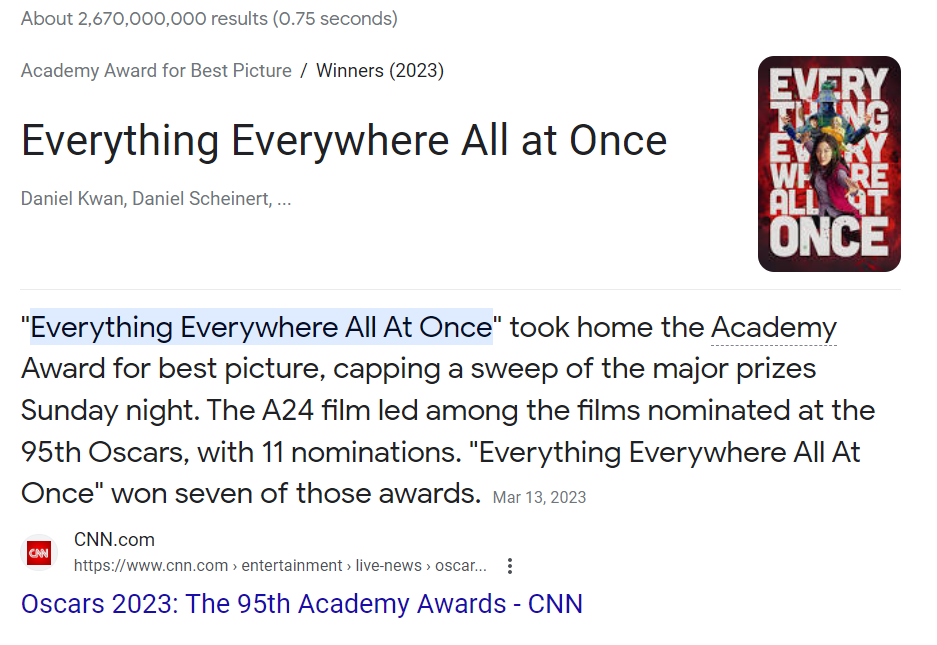

```json
{
    ...
    "answer_box": {
    "type": "organic_result",
    "title": "Academy Award for Best Picture/Winners (2023)",
    "link": "https://www.cnn.com/entertainment/live-news/oscars-2023/index.html",
    "displayed_link": "https://www.cnn.com › entertainment › live-news › oscar...",
    "date": "Mar 13, 2023",
    "snippet": "'Everything Everywhere All At Once' wins best picture at 2023 Oscars.",
    "snippet_highlighted_words": [
      "Everything Everywhere All At Once"
    ],
    "answer": "Everything Everywhere All at Once",
    "thumbnail": "https://serpapi.com/searches/6435b3c8eb690f61942b976f/images/9bdf5ebdf49028b3cf7b45395020c08e73978d3ebcd19362.jpeg",
    ...
}
```

In [19]:
res = results["answer_box"]["answer"]
res

'Everything Everywhere All at Once'

### Option 2: Build system prompt from search results (stuffed)

In [21]:
res = results["organic_results"]
res[0]

{'position': 1,
 'title': '2023 | Oscars.org | Academy of Motion Picture Arts and ...',
 'link': 'https://www.oscars.org/oscars/ceremonies/2023',
 'displayed_link': 'https://www.oscars.org › oscars › ceremonies › 2023',
 'snippet': 'Nominees · All Quiet on the Western Front · The Batman · Black Panther: Wakanda Forever · Top Gun: Maverick.',
 'snippet_highlighted_words': ['The Batman'],
 'about_this_result': {'source': {'description': "The Academy Awards, also known as the Oscars, are awards for artistic and technical merit for the film industry. They are presented annually by the Academy of Motion Picture Arts and Sciences, in recognition of excellence in cinematic achievements as assessed by the Academy's voting membership.",
   'source_info_link': 'https://www.oscars.org/oscars/ceremonies/2023',
   'security': 'secure',
   'icon': 'https://serpapi.com/searches/6436ef6066440a97af863faa/images/401af550b734562a90f29b798cc8f32604fde2adb2dc3e082e4717301fc4ce6093dadcfb4c6d31f912e9814a5bec

In [22]:
res[0]['link']

'https://www.oscars.org/oscars/ceremonies/2023'

In [24]:
from bs4 import BeautifulSoup
html = requests.get(res[0]['link']).content
soup = BeautifulSoup(html,'html.parser')
text = soup.get_text()
text

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n2023 | Oscars.org | Academy of Motion Picture Arts and Sciences\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to main content\n \n\n\n\nMenu\n\n\n\n\n\n\n\n\n\n\n\n\nSearch form\n\nSearch this site \n\n\n\n\n\n \n\n\n\n\n\n\n\nMembers Login\n\n\n\n\n\nSearch\n\n\n\nHome\nAwardsOscars\nGovernors Awards\nStudent Academy Awards\nScientific and Technical Awards\n\nMuseum/CollectionsAcademy Museum\nAcademy Film Archive\nMargaret Herrick Library\nOral Histories\nCollection Highlights\nAcademy Museum Store\n\nSupport and ShopMake a Gift to the Museum\nMake a Gift to the Academy Foundation\nAcademy Museum Store\n\nLearnHow To Become a Member\nGold Rising\nNicholl Fellowships\nFellowship for Women\nAcademy Museum Education Program\nCareers in Film\nAlumni Program\nSCIENCE AND TECHNOLOGY COUNCIL\n\nNewsA.frame Magazine\nNews and Updates\n\nMember Login\n\n\n\n\n\n\nYou are hereHome / Oscars / Oscars® Ceremonies / 2023 \n2023\n\n\nOscars® C

In [25]:
import tiktoken
encoding_name = 'cl100k_base'
encoding = tiktoken.get_encoding(encoding_name)
num_tokens = len(encoding.encode(text))
num_tokens

5219

### Alternative Search approach

In [62]:
from bs4 import BeautifulSoup
import requests
url = f'https://www.google.com/search?q={prompt}'
html = requests.get(url).text
with open('search.html','w') as f:
    f.write(html)
# Get the text of the webpage
soup = BeautifulSoup(html, "html.parser")
text = soup.get_text()
len(text)

3936

https://practicaldatascience.co.uk/data-science/how-to-scrape-google-search-results-using-python

In [5]:
import requests
import urllib
import pandas as pd
from requests_html import HTML
from requests_html import HTMLSession

In [6]:
def get_source(url):
    """Return the source code for the provided URL. 

    Args: 
        url (string): URL of the page to scrape.

    Returns:
        response (object): HTTP response object from requests_html. 
    """

    try:
        session = HTMLSession()
        response = session.get(url)
        return response

    except requests.exceptions.RequestException as e:
        print(e)

In [2]:
import urllib
prompt = 'What movie won best picture in 2023?'
query = urllib.parse.quote_plus(prompt)
query

'What+movie+won+best+picture+in+2023%3F'

In [7]:
response = get_source("https://www.google.co.uk/search?q=" + query)
response

<Response [200]>

In [8]:
links = list(response.html.absolute_links)
links

['https://www.rottentomatoes.com/m/everything_everywhere_all_at_once',
 'https://www.youtube.com/watch?v=hPXERpDTf5o',
 'https://www.google.co.uk/search?q=The+Whale&stick=H4sIAAAAAAAAAONgFuLVT9c3NEwrKrSszDYvU4JwC0zN0k0MDSu0eH3zyzJTgzNTUssTK4sXsXKGZKQqhGck5qQCAL3Li9c7AAAA&sa=X&ved=2ahUKEwiy7eeRlqP-AhULXaQEHVfTAeYQxA16BAgdEAQ',
 'https://www.google.co.uk/search?q=Top+Gun+2&stick=H4sIAAAAAAAAAONgFuLVT9c3NEwrKrSszDYvU-LSz9U3yK0qyTay0OL1zS_LTA3OTEktT6wsXsTKGZJfoOBemqdgBABcCkNPOAAAAA&sa=X&ved=2ahUKEwiy7eeRlqP-AhULXaQEHVfTAeYQxA16BAgdEA4',
 'https://www.google.co.uk/search?q=Academy+Award+for+Best+Picture&si=AMnBZoFk_ppfOKgdccwTD_PVhdkg37dbl-p8zEtOPijkCaIHMqYcd9KGWj9wRqQtGBsySONXEkxcFY9Un11qg_sjI0Gv4oH-kzjtoNd4O9utf786x_4ivcV4XP14yhPkvMh-1cmOEG408vuhxS7UtrYAVZevmDPtLhcLk8yIUERo9kEZ1YLoQniw-5vhZb-O9kBo0-1WIY2A3-mrdVnN8EEpbMiYi8B7Rgm7WLU0IZdCzznoB0H-AlpJY9pfODObpbUtsWyuN9zqK0Ty7208UwPpqXwSEb8XG6nngM9eyKdHTslyLp8XWas%3D&sa=X&ved=2ahUKEwiy7eeRlqP-AhULXaQEHVfTAeYQmxMoAHoECFoQAg',
 'https://support

In [9]:
# parse_results(response)
    
css_identifier_result = ".tF2Cxc"
css_identifier_title = "h3"
css_identifier_link = ".yuRUbf a"
css_identifier_text = ".VwiC3b"

results = response.html.find(css_identifier_result)

output = []

for result in results:

    item = {
        'title': result.find(css_identifier_title, first=True).text,
        'link': result.find(css_identifier_link, first=True).attrs['href'],
        'text': result.find(css_identifier_text, first=True).text
    }
    
    output.append(item)
output

[{'title': '2023 | Oscars.org | Academy of Motion Picture Arts and ...',
  'link': 'https://www.oscars.org/oscars/ceremonies/2023',
  'text': 'Nominees · All Quiet on the Western Front · The Batman · Black Panther: Wakanda Forever · Top Gun: Maverick.'},
 {'title': 'Oscars 2023: The 95th Academy Awards',
  'link': 'https://www.cnn.com/entertainment/live-news/oscars-2023/index.html',
  'text': 'Mar 13, 2023 — "Everything Everywhere All At Once" took home the Academy Award for best picture, capping a sweep of the major prizes Sunday night. The A24 film\xa0...'},
 {'title': "2023 Oscars chose wrong best picture in 'Everything ...",
  'link': 'https://www.latimes.com/entertainment-arts/awards/story/2023-03-12/oscars-2023-everything-everywhere-all-at-once-best-picture',
  'text': 'Mar 12, 2023 — "Everything Everywhere All at Once" wins Best Picture at the 95th Academy Awards. “Everything Everywhere All at Once” wins Best Picture at the\xa0...'},
 {'title': "'Everything Everywhere All at Onc